# Emotion Detection APS360 Project

## Data Extraction and Pre-Processing

The data, provided by [Ryerson](https://zenodo.org/record/1188976#.XnJ2at-YUax), is downloaded as video files of actors displaying emotions. We unzip the directories for each actor. We then sample the videos to extract a still image of the actor displaying an emotion. Actors 1-14 are used in the train data, actors 15-19 are used in the validation set, and actors 20-24 are used in the test set.

In [1]:
import os

In [ ]:
# unzip files
for i in os.listdir("."):
    if(i.endswith(".zip")):
        os.system("unzip "+i)

In [3]:
def makeDirs():
    for i in ['train', 'test', 'val']:
        os.system("mkdir " + i)
        os.chdir(i)
        for i in ["Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]:
            os.system("mkdir "+ i)
        os.chdir("..")

In [4]:
makeDirs()

In [5]:
os.listdir(".")

['model_EmotionNet_bs32_lr0.01_epoch58',
 'model_EmotionNet_bs32_lr0.01_epoch145',
 'model_EmotionNet_bs32_lr0.01_epoch20',
 'model_EmotionNet_bs32_lr0.01_epoch17',
 'model_EmotionNet_bs32_lr0.01_epoch126',
 'model_EmotionNet_bs32_lr0.01_epoch66',
 'model_EmotionNet_bs32_lr0.01_epoch170',
 'model_EmotionNet_bs32_lr0.01_epoch46',
 'model_EmotionNet_bs32_lr0.01_epoch193',
 'model_EmotionNet_bs32_lr0.01_epoch74',
 'model_EmotionNet_bs32_lr0.01_epoch118',
 'model_EmotionNet_bs32_lr0.01_epoch93',
 'model_EmotionNet_bs32_lr0.01_epoch53',
 'model_EmotionNet_bs32_lr0.01_epoch68',
 'model_EmotionNet_bs32_lr0.01_epoch164',
 'model_EmotionNet_bs32_lr0.01_epoch200',
 'model_EmotionNet_bs32_lr0.01_epoch177',
 'Actor_10',
 'model_EmotionNet_bs32_lr0.01_epoch45',
 'model_EmotionNet_bs32_lr0.01_epoch192',
 'Actor_21',
 'Actor_20',
 'model_EmotionNet_bs32_lr0.01_epoch29',
 'model_EmotionNet_bs32_lr0.01_epoch94',
 'model_EmotionNet_bs32_lr0.01_epoch96',
 'Actor_18',
 'model_EmotionNet_bs32_lr0.01_epoch1

In [6]:
def ffmpegIt(filename):
    output_name = "test"
    a = os.system("ffmpeg -i " + filename + " -vf fps=5/3 " + " %04d.jpg")

In [7]:
def renameFiles(direc, newdirec, counter, switch):
    if (switch <= 14):
        for filename in os.listdir(direc):
            if filename.endswith(".jpg"):
                os.system("mv " + filename + " train/" + newdirec + "/" + str(counter) + ".jpg")
                counter += 1
    elif(switch <= 19):
        for filename in os.listdir(direc):
            if filename.endswith(".jpg"):
                os.system("mv " + filename + " val/" + newdirec + "/" + str(counter) + ".jpg")
                counter += 1
    else:
        for filename in os.listdir(direc):
            if filename.endswith(".jpg"):
                os.system("mv " + filename + " test/" + newdirec + "/" + str(counter) + ".jpg")
                counter += 1   
    return counter

In [8]:
counter = 0
counter2 = 0
for direc in os.listdir("."):
    if direc[:5] == "Actor":
        counter2 += 1
        for filename in os.listdir("./" + direc): 
            if filename[:2] == '01': #Video format
                if filename[9:11] == '02': #intensity 
                    #if filename[6:8] == '01':
                    #    ffmpegIt(direc + "/" + filename)
                    #    counter = renameFiles(".", "Neutral", counter, counter2)
                    if filename[6:8] == '02':
                        ffmpegIt(direc + "/" + filename)
                        counter = renameFiles(".", "Calm", counter, counter2)
                    elif filename[6:8] == '03':
                        ffmpegIt(direc + "/" + filename)
                        counter = renameFiles(".", "Happy", counter, counter2)
                    elif filename[6:8] == '04':
                        ffmpegIt(direc + "/" + filename)
                        counter = renameFiles(".", "Sad", counter, counter2)
                    elif filename[6:8] == '05':
                        ffmpegIt(direc + "/" + filename)
                        counter = renameFiles(".", "Angry", counter, counter2)
                    elif filename[6:8] == '06':
                        ffmpegIt(direc + "/" + filename)
                        counter = renameFiles(".", "Fearful", counter, counter2)
                    elif filename[6:8] == '07':
                        ffmpegIt(direc + "/" + filename)
                        counter = renameFiles(".", "Disgust", counter, counter2)
                    elif filename[6:8] == '08':
                        ffmpegIt(direc + "/" + filename)
                        counter = renameFiles(".", "Surprised", counter, counter2)

In [1]:
#Data is split by actor => no actor is in any combination of train/val/test 

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [3]:
 # Transform Settings - Down scale the images
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
batch_size = 1
transform = transforms.Compose([transforms.Resize((90,160)), # (1080,1920) (hight, width)
                                transforms.CenterCrop(80),
                                transforms.ToTensor()])

trainFolder = torchvision.datasets.ImageFolder("train", transform=transform)
valFolder = torchvision.datasets.ImageFolder("val", transform=transform)
testFolder = torchvision.datasets.ImageFolder("test", transform=transform)

In [4]:
train_loader = torch.utils.data.DataLoader(trainFolder, batch_size=batch_size, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(valFolder, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(testFolder, batch_size=batch_size, num_workers=1, shuffle=True)

In [5]:
  # random 1 batch_size of train data in a small loader
  small_idx = np.array(range(len(trainFolder)))
  
  np.random.shuffle(small_idx)
  small_idx = small_idx[:32*batch_size]
  small_sampler = SubsetRandomSampler(small_idx)
  small_loader = torch.utils.data.DataLoader(trainFolder, batch_size=batch_size,
                                             num_workers=1, sampler=small_sampler)

## Verify Data loaded correctly

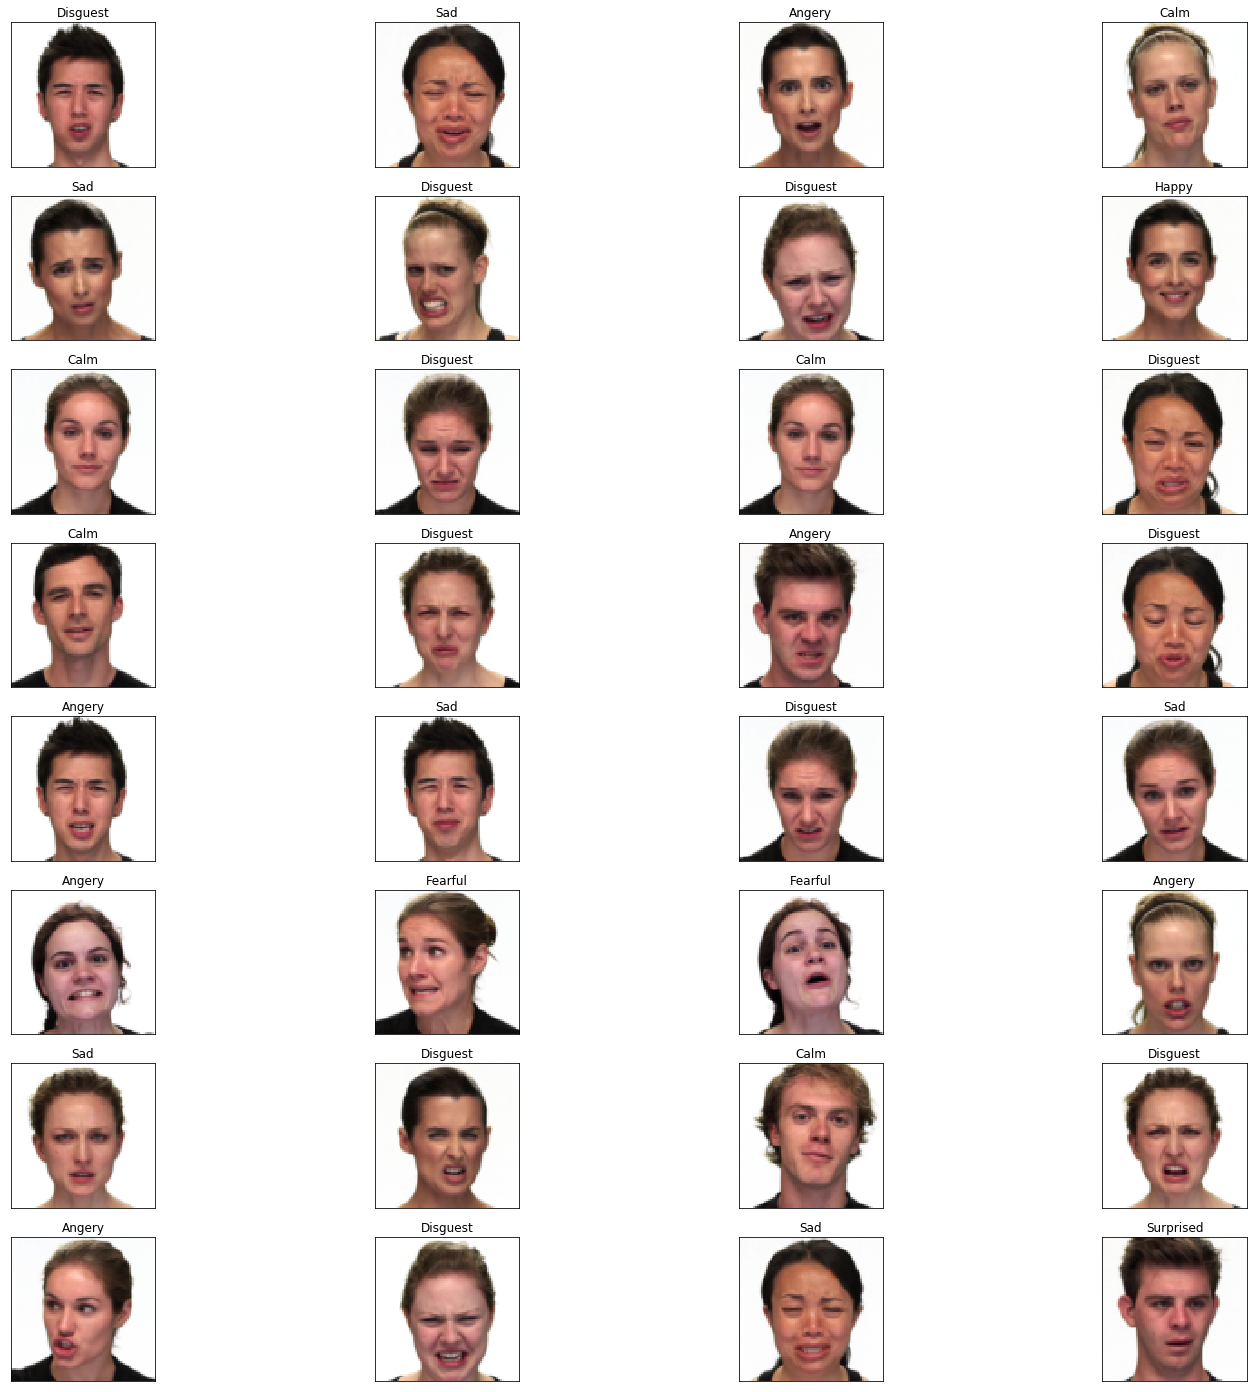

In [12]:
# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Sad', 'Surprised']

# plot the images in the batch, along with the corresponding labels
height = batch_size/4
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(height, batch_size/height, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
for img, label in small_loader:
    print(classes[label[0]])
    print(label)
    plt.imshow(np.transpose(img[0], (1, 2, 0)))
    plt.show()

## Model

### Model modifications

1. Made a 4 layer network with 2 conv layers and 2 ann layers. The conv layers each had a pooling layer

1. Increased the size of the Ann layers to 4 layers, in an attempt to overfit the data.

1. Returned the ANN layers back to 2 layers, and the 4 layers did not provide a benefit.

In [24]:
torch.manual_seed(1) # set the random seed

class EmotionNet(nn.Module):
    def __init__(self):
        super(EmotionNet, self).__init__()
        self.name = "EmotionNet_IntenseOnly"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(10*18*18, 18*18)
        self.fc2 = nn.Linear(18*18, 32)
        self.fc3 = nn.Linear(32, 7)

    def forward(self, img):
        x = self.pool1(F.relu(self.conv1(img)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print("shape", x.shape)
        x = x.view(-1, 10*18*18)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training Code

In [11]:
def normalize_label(labels_raw):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    # convert lable to an array of 7
    labels = np.zeros((len(labels_raw), 7))
    labels[range(len(labels_raw)), labels_raw] = 1
    return torch.tensor(labels)

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    if len(loader) == 0:
       return (0, 0)
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels_raw = data
        labels = normalize_label(labels_raw)
        
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels_raw = labels_raw.cuda()
          labels = labels.cuda()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        correct = outputs.argmax(1) == labels_raw
        
        total_acc += int(correct.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
        
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

def get_accuracy(model, data_loader, criterion):
    if(len(data_loader) == 0):
        return 0,0
    
    correct = 0
    total = 0
    total_loss = 0.0
    print("len data_loader", len(data_loader))
    i=0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        loss = criterion(output, labels)
        
        print("output:", output)
        print("labels:", labels)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
                
        total_loss += float(loss)
        print("idx:", i)
        i+=1
        print("loss.item():", total_loss)
        print("labels:", labels.shape)
        
    return (correct/total, total_loss/(len(data_loader)))

def train_net(net, train_loader, val_loader, batch_size=32, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    print("Use Cuda:", torch.cuda.is_available())
    print("Train loader size:", len(train_loader))
    print("Val loader size:", len(val_loader))
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Set the net to use Cuda if it is available
    if torch.cuda.is_available():
        net.cuda()
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    # print("Starting to learn")
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels_raw = data
            labels = normalize_label(labels_raw)

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels_raw = labels_raw.cuda()
                labels = labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_err[epoch], train_loss[epoch] = evaluate(net, train_loader, criterion)
        # print("starting validation")
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train acc: {:.3f}, Train loss: {:.3f} |"+
               "Val acc: {:.3f}, Val loss: {:.3f}| time: {:.2f}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch],
                   time.time()-start_time))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch+1)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    plot_training_curve(model_path)

## Overfitting to small subset

Use Cuda: True
Train loader size: 32
Val loader size: 0
Epoch 1: Train acc: 0.125, Train loss: 0.539 |Val acc: 0.000, Val loss: 0.000| time: 0.94
Epoch 2: Train acc: 0.156, Train loss: 0.381 |Val acc: 0.000, Val loss: 0.000| time: 1.93
Epoch 3: Train acc: 0.188, Train loss: 0.385 |Val acc: 0.000, Val loss: 0.000| time: 2.91
Epoch 4: Train acc: 0.219, Train loss: 0.375 |Val acc: 0.000, Val loss: 0.000| time: 3.89
Epoch 5: Train acc: 0.219, Train loss: 0.364 |Val acc: 0.000, Val loss: 0.000| time: 4.88
Epoch 6: Train acc: 0.219, Train loss: 0.375 |Val acc: 0.000, Val loss: 0.000| time: 5.85
Epoch 7: Train acc: 0.219, Train loss: 0.360 |Val acc: 0.000, Val loss: 0.000| time: 6.81
Epoch 8: Train acc: 0.219, Train loss: 0.360 |Val acc: 0.000, Val loss: 0.000| time: 7.79
Epoch 9: Train acc: 0.188, Train loss: 0.363 |Val acc: 0.000, Val loss: 0.000| time: 8.76
Epoch 10: Train acc: 0.219, Train loss: 0.359 |Val acc: 0.000, Val loss: 0.000| time: 9.72
Epoch 11: Train acc: 0.219, Train loss: 0.3

Epoch 90: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 88.07
Epoch 91: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 89.09
Epoch 92: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 90.05
Epoch 93: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 91.03
Epoch 94: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 91.99
Epoch 95: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 92.95
Epoch 96: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 93.92
Epoch 97: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 94.90
Epoch 98: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 95.87
Epoch 99: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 96.83
Epoch 100: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000|

Epoch 178: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 177.06
Epoch 179: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 178.04
Epoch 180: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 179.03
Epoch 181: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 180.00
Epoch 182: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 180.96
Epoch 183: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 181.92
Epoch 184: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 182.89
Epoch 185: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 183.88
Epoch 186: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 184.84
Epoch 187: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 185.80
Epoch 188: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.0

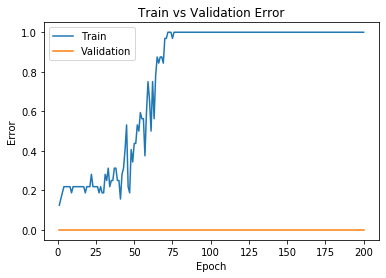

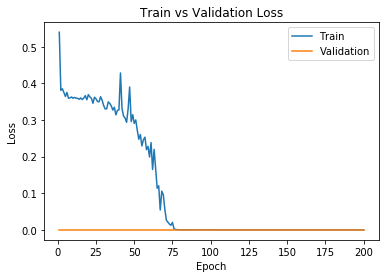

In [143]:
"""
Overfitted data use the new BCEWithLogitsLoss, and SGD formulas.
"""
net = EmotionNet()
if torch.cuda.is_available():
  net.cuda()

train_net(net, small_loader, [], num_epochs=200, learning_rate=0.01, batch_size=batch_size)

## Training the Model

Use Cuda: True
Train loader size: 164
Val loader size: 59
Epoch 1: Train acc: 0.139, Train loss: 0.374 |Val acc: 0.135, Val loss: 0.374| time: 132.74
Epoch 2: Train acc: 0.175, Train loss: 0.374 |Val acc: 0.191, Val loss: 0.374| time: 265.48
Epoch 3: Train acc: 0.142, Train loss: 0.372 |Val acc: 0.146, Val loss: 0.373| time: 398.60
Epoch 4: Train acc: 0.197, Train loss: 0.368 |Val acc: 0.166, Val loss: 0.370| time: 528.10
Epoch 5: Train acc: 0.228, Train loss: 0.359 |Val acc: 0.202, Val loss: 0.367| time: 652.62
Epoch 6: Train acc: 0.205, Train loss: 0.363 |Val acc: 0.168, Val loss: 0.377| time: 773.71
Epoch 7: Train acc: 0.232, Train loss: 0.352 |Val acc: 0.189, Val loss: 0.370| time: 895.14
Epoch 8: Train acc: 0.226, Train loss: 0.349 |Val acc: 0.182, Val loss: 0.371| time: 1017.61
Epoch 9: Train acc: 0.258, Train loss: 0.346 |Val acc: 0.195, Val loss: 0.376| time: 1139.04
Epoch 10: Train acc: 0.262, Train loss: 0.346 |Val acc: 0.202, Val loss: 0.377| time: 1259.51
Epoch 11: Train ac

Epoch 88: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.292, Val loss: 1.961| time: 10785.76
Epoch 89: Train acc: 0.998, Train loss: 0.002 |Val acc: 0.301, Val loss: 2.116| time: 10900.29
Epoch 90: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.307, Val loss: 1.959| time: 11014.90
Epoch 91: Train acc: 1.000, Train loss: 0.001 |Val acc: 0.304, Val loss: 2.149| time: 11129.57
Epoch 92: Train acc: 0.993, Train loss: 0.007 |Val acc: 0.304, Val loss: 2.086| time: 11244.20
Epoch 93: Train acc: 0.999, Train loss: 0.003 |Val acc: 0.292, Val loss: 1.926| time: 11358.70
Epoch 94: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.296, Val loss: 2.229| time: 11473.36
Epoch 95: Train acc: 1.000, Train loss: 0.001 |Val acc: 0.295, Val loss: 2.250| time: 11587.81
Epoch 96: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.293, Val loss: 2.121| time: 11702.36
Epoch 97: Train acc: 0.998, Train loss: 0.003 |Val acc: 0.286, Val loss: 2.124| time: 11816.95
Epoch 98: Train acc: 1.000, Train loss: 0.001 |Val

Epoch 174: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.034| time: 20643.60
Epoch 175: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.061| time: 20758.32
Epoch 176: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.057| time: 20872.88
Epoch 177: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.036| time: 20987.58
Epoch 178: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.295, Val loss: 3.053| time: 21102.16
Epoch 179: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.037| time: 21216.72
Epoch 180: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.035| time: 21331.42
Epoch 181: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.071| time: 21446.03
Epoch 182: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.060| time: 21560.62
Epoch 183: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.067| time: 21675.24
Epoch 184: Train acc: 1.000, Train loss:

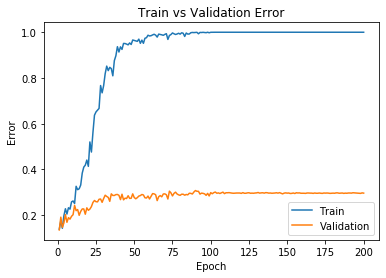

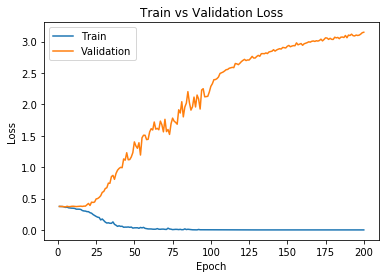

In [48]:
"""
Overfitted data use the new BCEWithLogitsLoss, and SGD formulas.

Peak acc of 30.7% @ e90.
"""
net = EmotionNet()
train_net(net, train_loader, val_loader, num_epochs=200, learning_rate=0.01, batch_size=batch_size)

## Train model with only intense emotions

When analyzing the data set, our method of randomly pulling frames from a video to capture the emotion did not fully work as we intended. Some images were caught as the actor was talking, and the emotion was not properly displayed. This caused the image to be misscategorized. To overcome this, we only include the intense subset of emotions, to help the model detect facial features.

Use Cuda: True
Train loader size: 79
Val loader size: 29
Epoch 1: Train acc: 0.150, Train loss: 0.412 |Val acc: 0.142, Val loss: 0.412| time: 62.55
Epoch 2: Train acc: 0.196, Train loss: 0.409 |Val acc: 0.171, Val loss: 0.410| time: 125.22
Epoch 3: Train acc: 0.243, Train loss: 0.408 |Val acc: 0.222, Val loss: 0.410| time: 187.96
Epoch 4: Train acc: 0.183, Train loss: 0.407 |Val acc: 0.172, Val loss: 0.410| time: 250.53
Epoch 5: Train acc: 0.225, Train loss: 0.404 |Val acc: 0.180, Val loss: 0.407| time: 312.66
Epoch 6: Train acc: 0.250, Train loss: 0.396 |Val acc: 0.186, Val loss: 0.404| time: 375.28
Epoch 7: Train acc: 0.257, Train loss: 0.391 |Val acc: 0.198, Val loss: 0.399| time: 440.58
Epoch 8: Train acc: 0.251, Train loss: 0.395 |Val acc: 0.262, Val loss: 0.401| time: 509.59
Epoch 9: Train acc: 0.256, Train loss: 0.385 |Val acc: 0.210, Val loss: 0.408| time: 574.04
Epoch 10: Train acc: 0.226, Train loss: 0.399 |Val acc: 0.185, Val loss: 0.433| time: 641.26
Epoch 11: Train acc: 0.

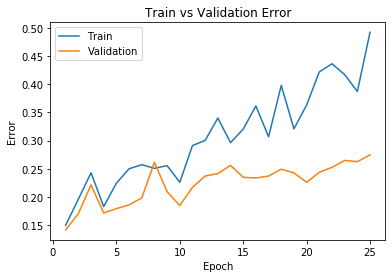

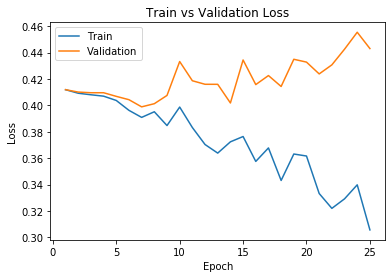

In [28]:
net = EmotionNet()
train_net(net, train_loader, val_loader, num_epochs=25, learning_rate=0.01, batch_size=batch_size)

## Train model with the Alex feature set

### Save the Alex features to a file

In [7]:
# Save Features to Folder (assumes code from 1. has been evaluated)

import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
master_path = 'alex-features-intense-only'

classes = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Sad', 'Surprised']

# save features to folder as tensors
for name, loader in [("train", train_loader), ("validation", val_loader), ("test", test_loader)]:
    print(name)
    n = 0
    for img, label in loader:
        features = alexnet.features(img)
        features_tensor = torch.from_numpy(features.detach().numpy())

        folder_name = master_path + '/' + name + '/' + str(classes[label])
        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
        torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
        n += 1

train
validation
test


### Load the Alex features from a file

In [38]:
# Load Tensor Files (features) from folder

#load features
# location on Google Drive
master_path = 'alex-features-intense-only'
train_set = torchvision.datasets.DatasetFolder(master_path+'/train', loader=torch.load, extensions=('.tensor'))
val_set = torchvision.datasets.DatasetFolder(master_path+'/validation', loader=torch.load, extensions=('.tensor'))
test_set = torchvision.datasets.DatasetFolder(master_path+'/test', loader=torch.load, extensions=('.tensor'))

# Prepare Dataloader
batch_size = 32
num_workers = 1
train_f_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_f_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_f_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
print("Train")
dataiter = iter(train_f_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)
print(len(train_f_loader))

print("Val")
dataiter = iter(val_f_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)
print(len(val_f_loader))

print("Test")
dataiter = iter(test_f_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)
print(len(test_f_loader))

Train
torch.Size([32, 256, 1, 1])
torch.Size([32])
44
Val
torch.Size([32, 256, 1, 1])
torch.Size([32])
17
Test
torch.Size([32, 256, 1, 1])
torch.Size([32])
27


## Alex Net Model

1. Built a simple 2 layer network with 256*1*1 -> 128 -> 7 Named: AlexEmotionNet

1. Built a 3 layer network 256->192->128->7.  Named: AlexEmotionNet-3layer. Had a peak Val accuracy of 33% on epoch 9.

1. Built a 4 layer network 256->192->128->64->7. Named: AlexEmotionNet-4layer. Had a peak Val accuracy of 28%. Decided to go back to a 3 layer network.

1. Went back to a 3 layer network. Changed the batch size to 64. Has a peak val accuracy of 32.5%.

1. Changed the learning rate to 0.001. Batch_size is 64. Has peak val accuracy of 25%.

1. Changed the learning rate to 0.005. Batch_size is 64. Has peak val accuracy of 31.7% @ epoch 17.

1. Learning rate set to 0.005, batch_size is 32. Has peak val accuracy of 33.6% @ epoch 16.

1. Lr 0.005, bs 16. Peak val accuracy of 32.8% @ e 80.

1. Changed to a 2 layer network. 256->192->7. lr 0.005, bs 16. Peak val acc of 32.6% @ e50.

In [39]:
torch.manual_seed(1) # set the random seed

class AlexASLNet(nn.Module):
    def __init__(self):
        super(AlexASLNet, self).__init__()
        self.name = "AlexEmotionNet-3layer"
        self.fc1 = nn.Linear(256*1*1, 192)
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 7)

    def forward(self, img):
        x = img.view(-1, 256*1*1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train Alex Net Model

Use Cuda: True
Train loader size: 44
Val loader size: 17
Epoch 1: Train acc: 0.171, Train loss: 0.409 |Val acc: 0.142, Val loss: 0.413| time: 0.59
Epoch 2: Train acc: 0.190, Train loss: 0.406 |Val acc: 0.213, Val loss: 0.409| time: 1.13
Epoch 3: Train acc: 0.231, Train loss: 0.404 |Val acc: 0.163, Val loss: 0.408| time: 1.68
Epoch 4: Train acc: 0.243, Train loss: 0.402 |Val acc: 0.209, Val loss: 0.406| time: 2.23
Epoch 5: Train acc: 0.224, Train loss: 0.401 |Val acc: 0.186, Val loss: 0.406| time: 2.76
Epoch 6: Train acc: 0.269, Train loss: 0.398 |Val acc: 0.257, Val loss: 0.404| time: 3.31
Epoch 7: Train acc: 0.336, Train loss: 0.396 |Val acc: 0.317, Val loss: 0.404| time: 3.86
Epoch 8: Train acc: 0.252, Train loss: 0.394 |Val acc: 0.286, Val loss: 0.399| time: 4.41
Epoch 9: Train acc: 0.294, Train loss: 0.391 |Val acc: 0.288, Val loss: 0.397| time: 4.96
Epoch 10: Train acc: 0.310, Train loss: 0.388 |Val acc: 0.257, Val loss: 0.397| time: 5.52
Epoch 11: Train acc: 0.344, Train loss: 0.

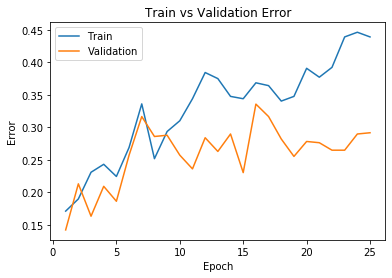

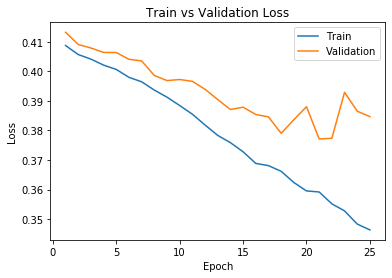

In [40]:
net = AlexASLNet()
train_net(net, train_f_loader, val_f_loader, num_epochs=25, learning_rate=0.005, batch_size=batch_size)